In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 64
N_EPOCHS = 10
INPUT_DIM = 28*28
LATENT_DIM = 2
N_CLASSES = 10

In [4]:
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n
    
    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)
    
    return onehot

In [5]:
transforms = transforms.Compose([transforms.ToTensor()])

In [6]:
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms,
                               )

In [7]:
test_dataset = datasets.MNIST('./data',
                              train=False,
                              download=True,
                              transform=transforms,
                              )

In [8]:
train_iterator = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

In [9]:
test_iterator = DataLoader(test_dataset,
                           batch_size=BATCH_SIZE,
                           )

In [10]:
class CVAE(nn.Module):
    
    def __init__(self, input_dim, latent_dim, n_classes):
        
        super().__init__()
        
        self.encoder = Encoder(input_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, input_dim, n_classes)
        
    def forward(self, x, y):
        
        x = torch.cat((x, y), dim=1)
        
        #encode
        mean, log_var = self.encoder(x)
        
        #reparameterize
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)
        
        z = torch.cat((z, y), dim=1)
        
        #decode
        x = self.decoder(z)
        
        return x, mean, log_var
    
class Encoder(nn.Module):
    
    def __init__(self, input_dim, latent_dim, n_classes):
        
        super().__init__()
        
        self.enc_1 = nn.Linear(input_dim+n_classes, 256)
        self.enc_21 = nn.Linear(256, latent_dim)
        self.enc_22 = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        
        x = F.relu(self.enc_1(x))
        mean = self.enc_21(x)
        log_var = self.enc_22(x)
        
        return mean, log_var
    
class Decoder(nn.Module):
    
    def __init__(self, latent_dim, output_dim, n_classes):
        
        super().__init__()
        
        self.dec_1 = nn.Linear(latent_dim+n_classes, 256)
        self.dec_2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
    
        x = F.relu(self.dec_1(x))
        x = F.sigmoid(self.dec_2(x))    
            
        return x

In [11]:
def reconstruction_loss(x, reconstructed_x, mean, log_var):
    
    BCE = F.binary_cross_entropy(reconstructed_x, x, size_average=False)

    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return BCE + KLD

In [12]:
model = CVAE(INPUT_DIM, LATENT_DIM, N_CLASSES).to(device)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train():
    
    model.train()
    train_loss = 0
    
    for i, (x, y) in enumerate(train_iterator):
        x = x.view(-1, 28*28)
        y = idx2onehot(y.view(-1, 1))
        x = x.to(device)
        y = y.to(device, dtype=x.dtype)
        optimizer.zero_grad()
        reconstructed_x, mean, log_var = model(x, y)
        loss = reconstruction_loss(x, reconstructed_x, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    return train_loss

In [15]:
def test():
    
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        
        for i, (x, y) in enumerate(test_iterator):
            x = x.view(-1, 28*28)
            y = idx2onehot(y.view(-1, 1))
            x = x.to(device)
            y = y.to(device, dtype=x.dtype)
            reconstructed_x, mean, log_var = model(x, y)
            loss = reconstruction_loss(x, reconstructed_x, mean, log_var)
            test_loss += loss.item()
        
    return test_loss

In [16]:
for e in range(N_EPOCHS):
    
    train_loss = train()
    test_loss = test()
    
    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

Epoch 0, Train Loss: 170.15, Test Loss: 148.57
Epoch 1, Train Loss: 144.50, Test Loss: 141.71
Epoch 2, Train Loss: 139.99, Test Loss: 138.86
Epoch 3, Train Loss: 137.86, Test Loss: 137.16
Epoch 4, Train Loss: 136.54, Test Loss: 136.22
Epoch 5, Train Loss: 135.66, Test Loss: 135.69
Epoch 6, Train Loss: 134.99, Test Loss: 134.86
Epoch 7, Train Loss: 134.45, Test Loss: 134.81
Epoch 8, Train Loss: 134.03, Test Loss: 134.23
Epoch 9, Train Loss: 133.62, Test Loss: 133.98


tensor([[ 1.1766,  0.1382]], device='cuda:0')
Generating a 0


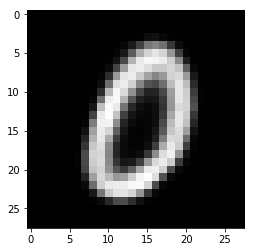

In [18]:
z = torch.randn(1, LATENT_DIM).to(device)
print(z)
y = torch.randint(0, N_CLASSES, (1,1)).to(dtype=torch.long)
print(f'Generating a {y.item()}')
y = idx2onehot(y).to(device, dtype=z.dtype)
z = torch.cat((z, y), dim=1)

reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28,28).data

plt.imshow(img, cmap='gray')

Generating number 4


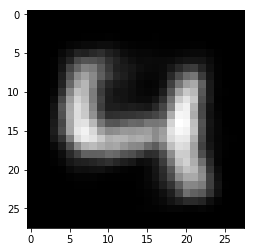

In [129]:
columns = 10
rows = 1
y = torch.randint(0, N_CLASSES, (1,1)).to(dtype=torch.long)
print(f'Generating number {y.item()}')
y = idx2onehot(y).to(device)
z = torch.cat((start, y), dim=1)
start = torch.randn(1, LATENT_DIM).to(device)
z = torch.cat((start, y), dim=1)
reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28,28).data
plt.imshow(img, cmap='gray')

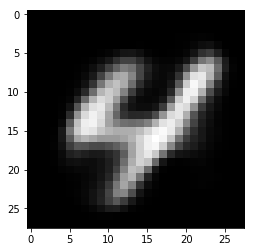

In [130]:
end = torch.randn(1, LATENT_DIM).to(device)

z = torch.cat((end, y), dim=1)
reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28,28).data
plt.imshow(img, cmap='gray')

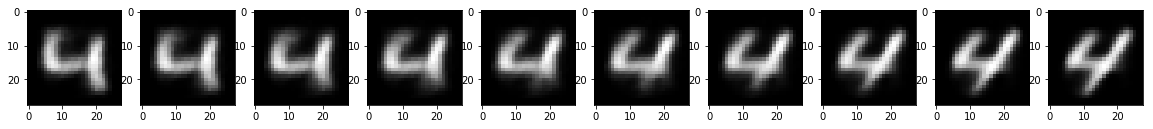

In [131]:
fig=plt.figure(figsize=(20, 20))

N_FIGURES = 10

for i in range(1, N_FIGURES+1):
    z = start*(1-((i-1)/(N_FIGURES-1))) + end*((i-1)/(N_FIGURES-1))
    z = torch.cat((z, y), dim=1)
    reconstructed_img = model.decoder(z)
    img = reconstructed_img.view(28,28).data
    fig.add_subplot(1, N_FIGURES, i)
    plt.imshow(img, cmap='gray')
plt.show()